In [1]:
!pip install pycaret
print("Pycaret installed sucessfully!!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 76.5 

In [2]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [3]:
data = pd.read_csv('/kaggle/input/co-and-nox-data/gt_2015.csv')
data.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [4]:
subcluster_sizes = [3, 4, 5]

In [5]:
# Define clustering algorithms
clustering_algorithms = {
    'KMeans': KMeans,
    'AgglomerativeClustering': AgglomerativeClustering,
    'DBSCAN': DBSCAN
}

In [6]:
# Initialize dictionaries to store results for each algorithm
results_dict = {algorithm_name: [] for algorithm_name in clustering_algorithms.keys()}

In [7]:
import warnings
# Ignore specific warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4.")

In [8]:
# Loop through different clustering algorithms
for algorithm_name, algorithm in clustering_algorithms.items():
    # Loop through different data processing methods
    for processing_method in ['No Data Processing', 'Normalization', 'Transformation', 'PCA', 'T+N', 'T+N+PCA']:
        for subcluster_size in subcluster_sizes:
            # Apply data processing based on the method
            processed_data = data.copy()  # Assume no processing by default
            if processing_method == 'Normalization':
                scaler = MinMaxScaler()
                processed_data = scaler.fit_transform(data)
            elif processing_method == 'Transformation':
                scaler = StandardScaler()
                processed_data = scaler.fit_transform(data)
            elif processing_method == 'PCA':
                pca = PCA(n_components=min(subcluster_size, data.shape[1]))
                processed_data = pca.fit_transform(data)
            elif processing_method == 'T+N':
                scaler = MinMaxScaler()
                transformed_data = scaler.fit_transform(data)
                processed_data = transformed_data
            elif processing_method == 'T+N+PCA':
                scaler = MinMaxScaler()
                transformed_data = scaler.fit_transform(data)
                pca = PCA(n_components=min(subcluster_size, data.shape[1]))
                processed_data = pca.fit_transform(transformed_data)
            
            # Perform clustering
            if algorithm_name == 'DBSCAN':
                clusters = algorithm(eps=0.5, min_samples=5).fit_predict(processed_data)
            else:
                clusters = algorithm(n_clusters=subcluster_size).fit_predict(processed_data)
            
            # Check if clustering generated valid clusters
            unique_labels = len(set(clusters))
            if unique_labels > 1:
                # Calculate evaluation metrics
                silhouette = silhouette_score(processed_data, clusters)
                calinski_harabasz = calinski_harabasz_score(processed_data, clusters)
                davies_bouldin = davies_bouldin_score(processed_data, clusters)
                
                # Append results to the list
                results_dict[algorithm_name].append({
                    'Algorithm': algorithm_name,
                    'Processing Method': processing_method,
                    'Subcluster Size': subcluster_size,
                    'Silhouette Score': silhouette,
                    'Calinski-Harabasz Score': calinski_harabasz,
                    'Davies-Bouldin Score': davies_bouldin
                })

In [9]:
# Create DataFrames for each algorithm
dfs = {}
for algorithm_name, results in results_dict.items():
    dfs[algorithm_name] = pd.DataFrame(results)

# Print the results in a beautiful table format
for algorithm_name, df in dfs.items():
    print(f"Clustering Algorithm: {algorithm_name}\n")
    print(df.to_string(index=False))
    print("\n\n")

Clustering Algorithm: KMeans

Algorithm  Processing Method  Subcluster Size  Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score
   KMeans No Data Processing                3          0.384585              2393.003014              0.954584
   KMeans No Data Processing                4          0.335492              2183.585336              1.063716
   KMeans No Data Processing                5          0.328471              2103.369150              1.117386
   KMeans      Normalization                3          0.380850              2379.455299              0.992413
   KMeans      Normalization                4          0.331213              2247.854376              1.062570
   KMeans      Normalization                5          0.328583              2072.797741              1.107599
   KMeans     Transformation                3          0.319812              1719.292632              1.148595
   KMeans     Transformation                4          0.288845              1580.

In [10]:
# Save results as CSV files
for algorithm_name, df in dfs.items():
    filename = f"{algorithm_name}_results.csv"
    df.T.to_csv(filename)
    print(f"{filename} saved successfully.\n")

KMeans_results.csv saved successfully.

AgglomerativeClustering_results.csv saved successfully.

DBSCAN_results.csv saved successfully.



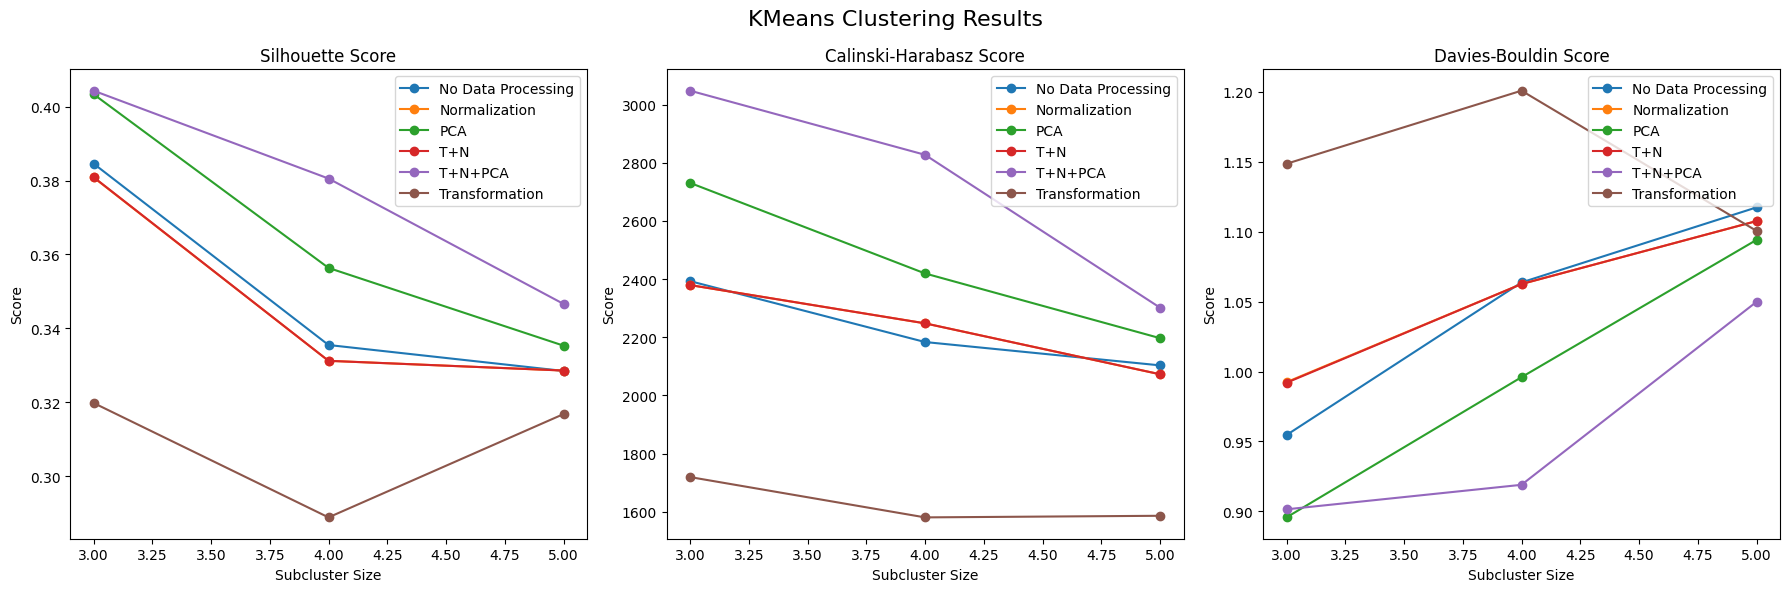

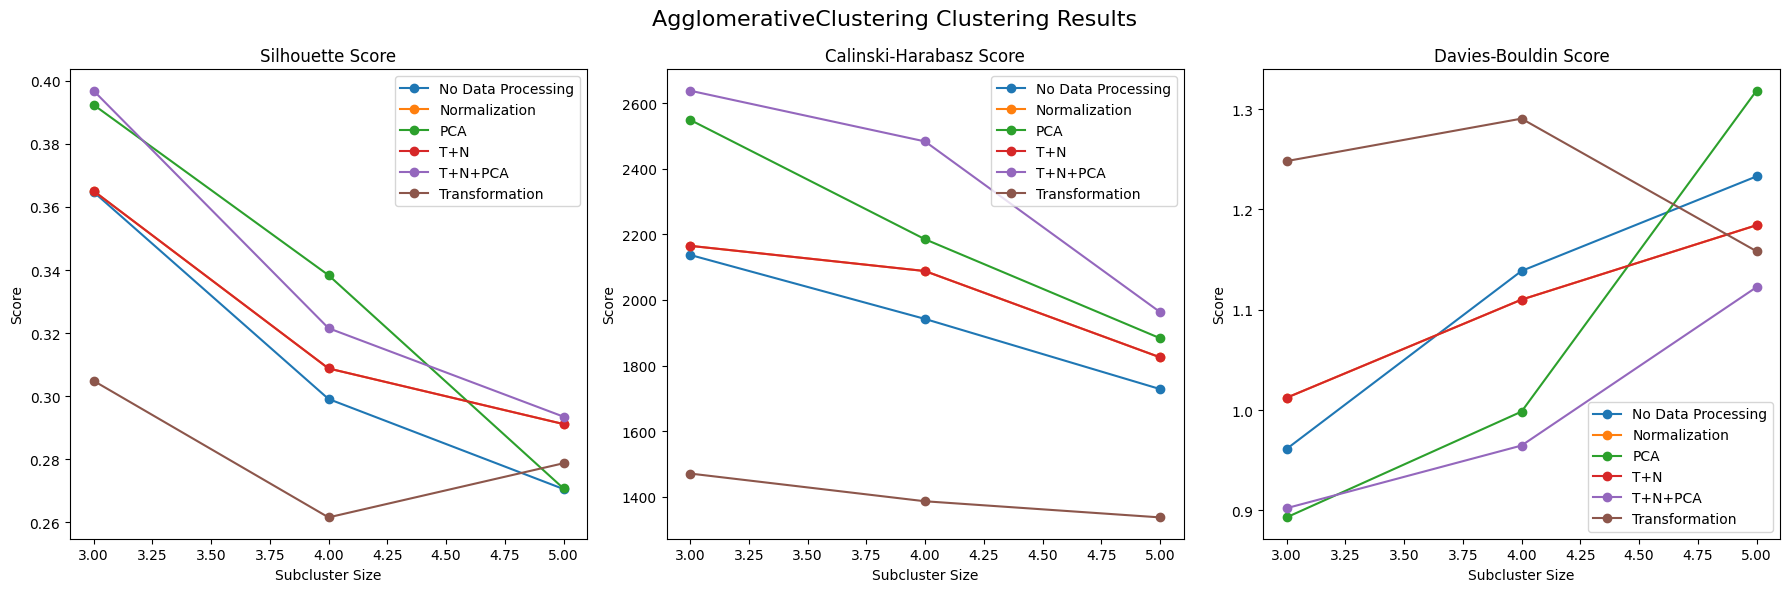

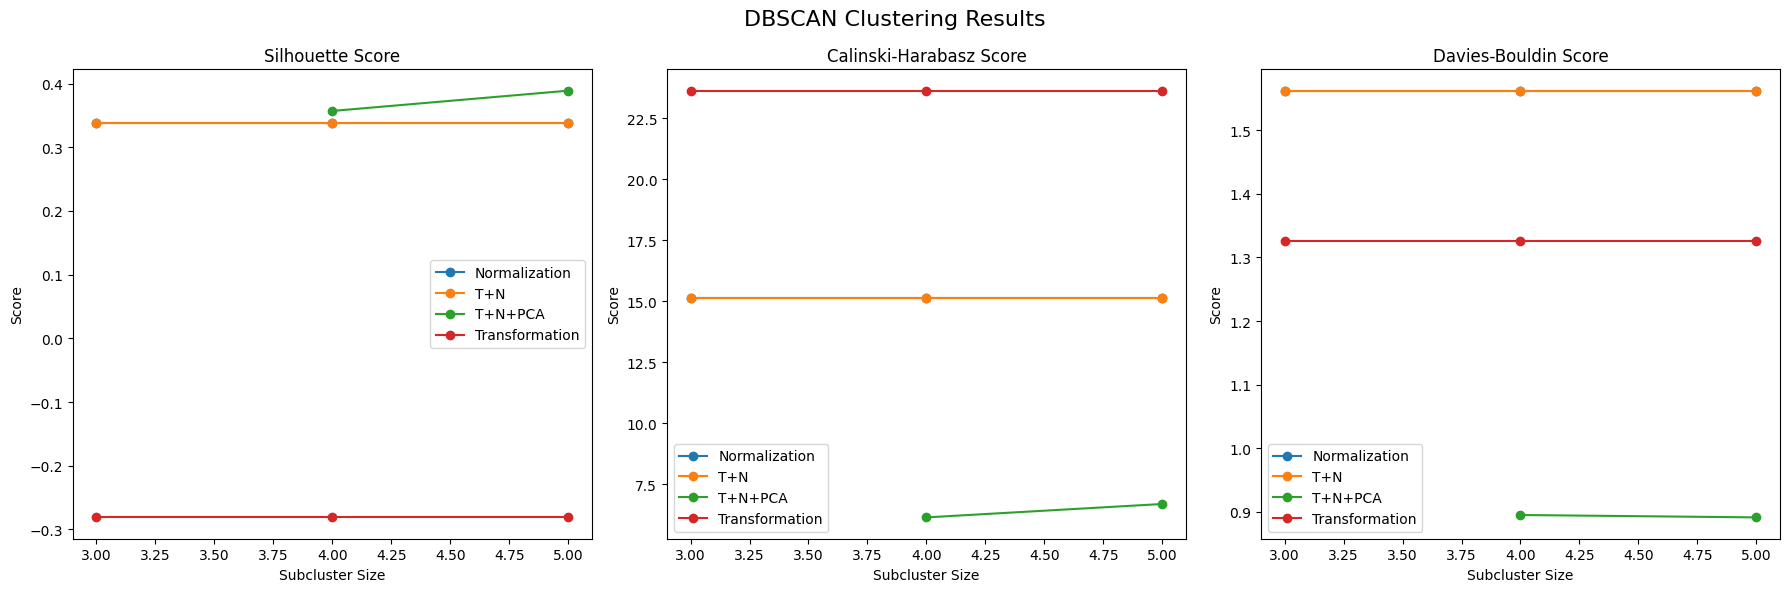

In [11]:
# Define function to plot graphs for each clustering algorithm
import matplotlib.pyplot as plt

def plot_results_per_algorithm(algorithm_name, df):
    # Create subplots for each metric
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot each metric
    for i, metric in enumerate(['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']):
        ax = axs[i]
        for method, method_df in df.groupby('Processing Method'):
            ax.plot(method_df['Subcluster Size'], method_df[metric], marker='o', label=method)
        ax.set_title(metric)
        ax.set_xlabel('Subcluster Size')
        ax.set_ylabel('Score')
        ax.legend()

    # Set title for the entire plot
    plt.suptitle(f'{algorithm_name} Clustering Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot results for each algorithm
for algorithm_name, df in dfs.items():
    plot_results_per_algorithm(algorithm_name, df)